#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [73]:
# !pip install skforecast

## Подготовка

In [74]:
import pandas as pd
import numpy as np
import warnings

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, ARDRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore")

In [75]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data = data.resample('1H').sum()
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Проверим, расположены ли даты в хронологическом порядке:

In [76]:
print(data.index.is_monotonic)

Размер датасета

In [77]:
data.shape

(4416, 1)

In [78]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [79]:
data.index.min(), data.index.max(),

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

## Анализ

In [80]:
data_copy = data.copy()

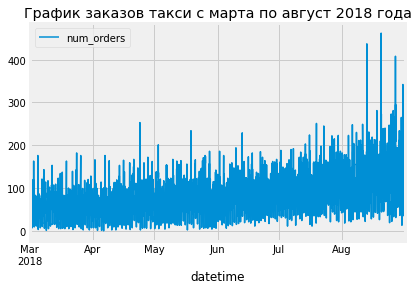

In [81]:
data_copy.plot()
plt.title("График заказов такси с марта по август 2018 года")
plt.show()

Text(0.5, 1.0, 'Seasonality')

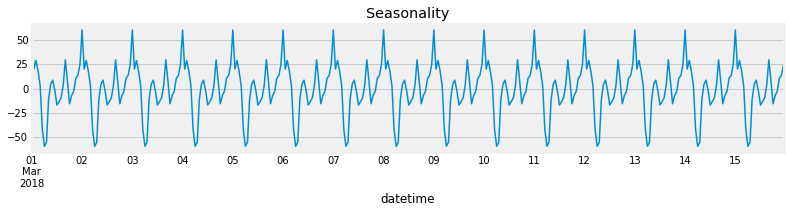

In [82]:
decomposed = seasonal_decompose(data_copy)

plt.figure(figsize=(12, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Seasonality')

Виден тренд на спад заказов на утренние часы и высокую активность на полуночные

<AxesSubplot:xlabel='datetime'>

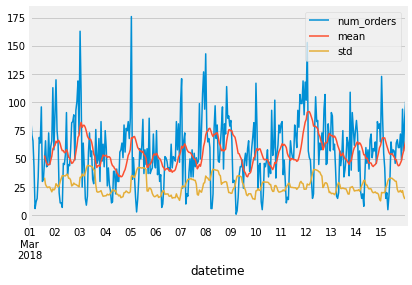

In [83]:
data_copy = data_copy['2018-03-01':'2018-03-15'].resample('1H').sum()
data_copy['mean'] = data_copy['num_orders'].rolling(15).mean()
data_copy['std'] = data_copy['num_orders'].rolling(15).std()
data_copy.plot()

Среднее распределения заказов так же имеет тренд.

In [84]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF: ", dftest[0])
    print("2. p-value: ", dftest[1])
    print("3. num of lags: ", dftest[2])
    print("4. num of observation used for adf regresion and critical values calculation: ", dftest[3])
    print("5. critical values:")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)



In [85]:
ad_test(data['num_orders'])

Здесь p-value должен быть как можно меньше, тогда можно сказать что dataset стационарный

### Разделение на выборки для обучения и тестирования

In [86]:
# Split train-val-test
# ==============================================================================
end_train = '2018-07-20 00:00:00'
end_validation = '2018-08-13 23:59:00'
data_train = data.loc[:end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Знаю, что здесь можно было использовать стандартное разбиение с shuffle. Но мне такое чуть понятнее в случае с временными рядами.

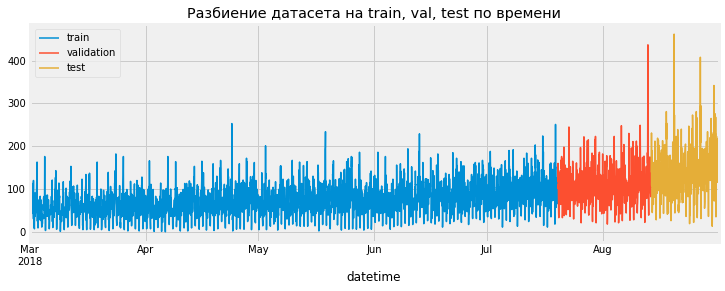

In [87]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_train['num_orders'].plot(ax=ax, label='train')
data_val['num_orders'].plot(ax=ax, label='validation')
data_test['num_orders'].plot(ax=ax, label='test')
ax.set_title('Разбиение датасета на train, val, test по времени')
ax.legend()
plt.show()

In [88]:
# Interactive plot of time series
# ==============================================================================
data.loc[:end_train, 'partition'] = 'train'
data.loc[end_train:end_validation, 'partition'] = 'validation'
data.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = data.reset_index(),
    x      = 'datetime',
    y      = 'num_orders',
    color  = 'partition',
    title  = 'Number of orders',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

data=data.drop(columns='partition')

## Обучение

In [89]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek

    for lag in range(1, max_lag + 1):
        new_data[f'lag_{lag}'] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

In [90]:
RANDOM_STATE = 12

In [91]:
def calc_best_params(est, param=None):
    best_params = {
        'min_rmse': np.inf,
    }
    for i in range(1, 10, 2):
        for j in range(1, 15, 2):
            max_lag = i
            rolling_mean_size = j
            data_train = data.loc[:end_train, :]
            data_val   = data.loc[end_train:end_validation, :]
            train = make_features(data_train, max_lag, rolling_mean_size)
            val = make_features(data_val, max_lag, rolling_mean_size)
            train.dropna(inplace=True)
            val.dropna(inplace=True)
            y_train, X_train = train['num_orders'], train.drop(columns='num_orders')
            y_val, X_val = val['num_orders'], val.drop(columns='num_orders')
            if param:
                model = est(gcv_mode=param)
            else:
                model = est()
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            # print("RMSE валидационной выборки:", mean_squared_error(y_val, y_val_pred) ** 0.5)
            if (mean_squared_error(y_val, y_val_pred) ** 0.5) < best_params['min_rmse']:
                best_params['min_rmse'] = (mean_squared_error(y_val, y_val_pred) ** 0.5)
                best_params['max_lag'] = i
                best_params['rolling_mean_size'] = j
    print(best_params)

### LinearRegression

In [92]:
calc_best_params(LinearRegression)

### RidgeCV

In [93]:
calc_best_params(RidgeCV, 'svd')

### ARDRegression

In [94]:
# calc_best_params(ARDRegression)
# Локально быстро отрабатывает, удаленно совсем нет

Из линейных моделей лучше всего себя показала Линейная регрессия

In [95]:
train = make_features(data_train, 9, 11)
val = make_features(data_val, 9, 11)
train.dropna(inplace=True)
val.dropna(inplace=True)
y_train, X_train = train['num_orders'], train.drop(columns='num_orders')
y_val, X_val = val['num_orders'], val.drop(columns='num_orders')

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_val_pred = model_lr.predict(X_val)
print("RMSE валидационной выборки:", mean_squared_error(y_val, y_val_pred) ** 0.5)

### RandomForestRegressor

In [96]:
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
)

In [97]:
train = make_features(data_train, 9, 11)
val = make_features(data_val, 9, 11)
train.dropna(inplace=True)
val.dropna(inplace=True)
y_train, X_train = train['num_orders'], train.drop(columns='num_orders')
y_val, X_val = val['num_orders'], val.drop(columns='num_orders')

model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=12)

In [98]:
y_val_pred = model_rf.predict(X_val)
print("RMSE валидационной выборки:", mean_squared_error(y_val, y_val_pred) ** 0.5)

Почти на уровне с регрессией

### CatBoostRegressor

In [99]:
forecaster = ForecasterAutoreg(
    regressor = CatBoostRegressor(random_state=123, silent=True),
    lags = 24
)

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x000001D5F05F1988> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-03-17 15:27:01 
Last fit date: None 
Skforecast version: 0.4.2 

In [100]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, 'num_orders'],
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(data_train)),
    return_best        = True,
    verbose            = False
)

In [101]:
results_grid.head(5)

,lags,params,metric,learning_rate,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",934.278458,0.10,5.0,500.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",966.908219,0.10,3.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",983.615970,0.10,5.0,100.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1032.790943,0.10,3.0,100.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1064.987210,0.01,5.0,500.0


In [102]:
data_train = data.loc[:end_train, :]
data_val   = data.loc[end_train:end_validation, :]
new_data_train = make_features(data_train, 72, 20)
new_data_val = make_features(data_val, 72, 20)
new_data_train.dropna(inplace=True)
new_data_val.dropna(inplace=True)
y_train, X_train = new_data_train['num_orders'], new_data_train.drop(columns='num_orders')
y_val, X_val = new_data_val['num_orders'], new_data_val.drop(columns='num_orders')

model_cb = CatBoostRegressor(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=500,
    loss_function='RMSE',
    random_state=RANDOM_STATE,
    silent=True,
)
# Fit model
model_cb.fit(X_train, y_train)
# Get predictions
y_val_pred = model_cb.predict(X_val)
print("RMSE валидационной выборки:", mean_squared_error(y_val, y_val_pred) ** 0.5)

Результат лучше чем у линейных моделей

## Тестирование

In [103]:
data_train = data.loc[:end_validation, :]
train = make_features(data_train, 9, 11)
test = make_features(data_test, 9, 11)
train.dropna(inplace=True)
test.dropna(inplace=True)
y_train, X_train = train['num_orders'], train.drop(columns='num_orders')
y_test, X_test = test['num_orders'], test.drop(columns='num_orders')

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_test_pred = model_lr.predict(X_test)
print("RMSE тестовой выборки:", mean_squared_error(y_test, y_test_pred) ** 0.5)

In [104]:
model_rf.fit(X_train, y_train)
y_test_pred = model_rf.predict(X_test)

print("RMSE тестовой тестовой для Случайного леса:", mean_squared_error(y_test, y_test_pred) ** 0.5)

In [105]:
data_train = data.loc[:end_validation, :]
train = make_features(data_train, 72, 20)
test = make_features(data_test, 72, 20)
train.dropna(inplace=True)
test.dropna(inplace=True)
y_train, X_train = train['num_orders'], train.drop(columns='num_orders')
y_test, X_test = test['num_orders'], test.drop(columns='num_orders')

# data_test  = data.loc[end_validation:, :]
# make_features(data_test, 72, 20)
# data_test.dropna(inplace=True)
# y_test, X_test = data_test['num_orders'], data_test.drop(columns='num_orders')
model_cb.fit(X_train, y_train)
y_test_pred = model_cb.predict(X_test)

print("RMSE тестовой выборки для Кэтбуста:", mean_squared_error(y_test, y_test_pred) ** 0.5)